---
<a name="import"></a>
## Import **DeepMReye**

In [1]:
# Import modules and add library to path
import sys
sys.path.insert(0, "/home/marx/Documents/Github/DeepMReye")

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # Change to os.environ["CUDA_VISIBLE_DEVICES"] = "" if you dont have access to a GPU
import numpy as np 
import pandas as pd
import gc
import pickle
import ants
from tensorflow.keras.backend import clear_session 

# DeepMReye imports
from deepmreye import architecture, train, analyse, preprocess
from deepmreye.util import util, data_generator, model_opts

# Initialize plotly figures
from plotly.offline import init_notebook_mode 
init_notebook_mode(connected = True)
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

# Make sure the output width is adjusted for better export as HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
display(HTML("<style>.output_result { max-width:70% !important; }</style>"))

# Autoreload modules
%load_ext autoreload
%autoreload 2

2022-05-10 17:45:12.670436: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


---
<a name="preprocessing"></a>
## Preprocessing
DeepMReye assumes the input to be a 4D NIFTI file (.nii) containing the functional (EPI) volumes over time. You may use one 4D file per run or concatinate all runs to one 4D file. For model training, it additionally requires the gaze labels measured with a camera-based eye tracker or instructed fixation locations for each functional volume in the 4D file. Preprocessing of the functional images other than realignment is unneccessary. We do however recommend to preprocess the eye-tracking data to reduce noise.
            
To select voxels corresponding to the eyeballs, our pipeline coregisters the 4D files non-linearly to a group template using a dedicated three-step warping procedure (see paper for details). This coregistration procedure is optimized for the eyeballs and generates new 4D images containing only the eyeball voxels. See example code for this coregistration procedure below.

In [2]:
# Define paths to functional data
experiment_folder = '/mnt/CYHSM/Projects/DeepMReye/data/ign/' # Replace this path to your downloaded files
functional_data = experiment_folder + 'functional_data/'
processed_data = experiment_folder + 'processed_data/'
gaze_data = experiment_folder + 'gaze_data/'
model_weights = experiment_folder + 'model_weights/'
# Create processed data folder if necessary
if not os.path.exists(processed_data):
    os.makedirs(processed_data)
if not os.path.exists(model_weights):
    os.makedirs(model_weights)

In [3]:
# Get participants from functional folder
participants = os.listdir(functional_data) # (if needed, remove single participants with participants.remove('participant01') or recreate participants list)
participants = [participants[1]]

# # Preload masks to save time within participant loop
# (eye_small, _, dme_template, _, _, _, _) = preprocess.get_masks(data_path='../../deepmreye/masks/') # Get template
# mec_mask = ants.image_read('/home/marx/Documents/Github/DeepMReye/notebooks/Brain ROIs/rpmEC_IP2mm.nii')
# (_, x_edges, y_edges, z_edges) = preprocess.get_mask_edges(mec_mask, split=False)

# # Loop across participants and extract eye mask
# for participant in participants:
#     print('Running participant {}'.format(participant))
#     participant_folder = functional_data + participant
#     for run in os.listdir(participant_folder):
#         if run.startswith('run'):
#             fp_func = participant_folder + os.path.sep + run + os.path.sep + '{}_{}.nii'.format(participant, run) # Filepath to functional
#             preprocess.run_participant(fp_func, dme_template, None, mec_mask, x_edges, y_edges, z_edges, mask_name='rpmec_', transforms=None)

Note that the pipeline produces diagnostic figures that can and should be carefully examined for each individual scanning run. These figures are saved as interactive html file together with the rest of the model output. Here is one such [html file](https://github.com/DeepMReye/DeepMReye/blob/main/tests/data/report_test_participant.html) as an example. If the alignment is off, try running above loop with:
```python
preprocess.run_participant(fp_func, dme_template, eyemask_big, eyemask_small, x_edges, y_edges, z_edges, transforms=['Affine', 'Affine', 'SyNAggro'])
```
which uses a more aggressive (and non-linear) alignment procedure. 

In [4]:
# Use custom load_label function
def load_label(subject_string, num_downsampled=10, bln_index=7): # bln_index 1 for original npy files
    """
    For models with multiple outputs we want to estimate the sub-TR XY 
    Inputs: 
        - subject_string : Subject identified
        - mat_data : Data to subject logs in mat format
        - num_downsampled : How many sub-TR XY are left in the output
    """
    subj_data = np.load(subject_string)
    np.testing.assert_(np.unique(np.diff(np.where(subj_data[:, 0] == 1)[0]))[0] == 510)

    all_labels, all_runs = [], []
    for idx, l in enumerate(subj_data):
        if l[bln_index] == 0:
            if all_labels:
                all_runs.append(np.array(all_labels))
            all_labels = []
        bln_tr = int(l[0])
        if bln_tr:
            if (idx + 510) >= subj_data.shape[0]:
                this_label = subj_data[np.linspace(idx, subj_data.shape[0] - 1, num_downsampled, dtype=int), :]
            else:
                this_label = subj_data[np.linspace(idx, idx + 510, num_downsampled, dtype=int), :]
            all_labels.append(this_label)
    all_runs.append(np.array(all_labels))
    all_runs = np.array(all_runs)

    return all_runs

def run_participants(participants, processed_data, chosen_mask='rpmec', chosen_speed=0.55, chosen_shift=0):
    # Combine processed masks with labels
    for participant in participants:
        all_participant_labels = load_label(gaze_data + participant + '_true_xyPos2.npy')

        print('Running participant {}'.format(participant))
        participant_folder = functional_data + participant
        participant_data, participant_ids, participant_labels = [], [], []
        for run_idx, run in enumerate(os.listdir(participant_folder)):
            # Load mask and normalize it
            this_mask = participant_folder + os.path.sep + run + os.path.sep + 'mask_{}_{}_{}.p'.format(chosen_mask, participant, run) 
            this_mask = pickle.load(open(this_mask, 'rb'))
            this_mask = preprocess.normalize_img(this_mask, standardize_tr=False)

            # Get rid of first four functionals
            this_mask = this_mask[...,4::]

            # Load labels (in visual angle)
            run_number = int(''.join(filter(str.isdigit, run))) - 1
            this_label = all_participant_labels[run_idx]        

            # Shift to accomodate BOLD effect
            if chosen_shift > 0:
                this_mask = this_mask[..., chosen_shift::]
                this_label = this_label[0:-chosen_shift, ...]
            
            this_speed = this_label[...,5]
            this_label = this_label[...,8:10]

            # Get rid of one speed
            label_speed_indices = np.all(this_speed==chosen_speed, axis=1)
            print('Chosing {} speed labels - {}'.format(np.sum(label_speed_indices) // 2, chosen_speed))
            this_mask = this_mask[...,label_speed_indices]
            this_label = this_label[label_speed_indices, :]
            
            # Get rid of slow moving ones
            this_label_mean = np.nanmean(this_label, axis=1)
            this_x_diff = np.diff(this_label_mean[..., 0], prepend=0)
            this_y_diff = np.diff(this_label_mean[..., 1], prepend=0)
            all_moving = (this_x_diff > 0.1) & (this_y_diff > 0.1)
            print('Chosing {} moving labels'.format(np.sum(all_moving)))
            this_mask = this_mask[...,all_moving]
            this_label = this_label[all_moving, :]            

            # Check if each functional image has a corresponding label. Note that mask has time as third dimension
            if not this_mask.shape[3] == this_label.shape[0]:
                print('WARNING --- Skipping Subject {} Run {} --- Wrong alignment (Mask {} - Label {}).'.format(participant, run_idx, this_mask.shape, this_label.shape))
                continue

            # Store across runs
            participant_data.append(this_mask)
            participant_labels.append(this_label)
            participant_ids.append(([participant]*this_label.shape[0], [run_idx]*this_label.shape[0], [chosen_speed]*this_label.shape[0]))

        # Save participant file
        preprocess.save_data(participant, participant_data, participant_labels, participant_ids, processed_data, center_labels=False)

In [5]:
# TTC: 0.55, 1.2, 0.67, 0.86

In [7]:
speeds = [0.55, 0.67, 0.86, 1.2]
masks = ['rpmec']
shifts = range(0, 11)

for chosen_mask in masks:
    for chosen_speed in speeds:
        print('Running mask {}, speed {}'.format(chosen_mask, chosen_speed))
        for chosen_shift in shifts:
            print(chosen_shift, end='\r')
            processed_data = '/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/' + '{}/speed{}/shift{}/'.format(chosen_mask, str(chosen_speed).replace('.',''), chosen_shift)
            if not os.path.exists(processed_data):
                os.makedirs(processed_data)
            run_participants(participants, processed_data, chosen_mask=chosen_mask, chosen_speed=chosen_speed, chosen_shift=chosen_shift)

Running mask rpmec, speed 0.55


/home/marx/miniconda3/envs/deepmreye/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/marx/Documents/Github/DeepMReye/deepmreye/preprocess.py:350: RuntimeWarning:

Mean of empty slice

/home/marx/miniconda3/envs/deepmreye/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning:

Degrees of freedom <= 0 for slice.



Running participant 05_O7K1
Chosing 68 speed labels - 0.55
Chosing 32 moving labels
Chosing 68 speed labels - 0.55
Chosing 27 moving labels
Chosing 67 speed labels - 0.55
Chosing 26 moving labels
Chosing 69 speed labels - 0.55
Chosing 29 moving labels
Saving eye data (114, 26, 16, 8) and targets (114, 10, 2) (NaN 0) to file /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift0/05_O7K1
Running participant 05_O7K1
Chosing 68 speed labels - 0.55
Chosing 32 moving labels
Chosing 68 speed labels - 0.55
Chosing 27 moving labels
Chosing 67 speed labels - 0.55
Chosing 26 moving labels
Chosing 69 speed labels - 0.55
Chosing 29 moving labels
Saving eye data (114, 26, 16, 8) and targets (114, 10, 2) (NaN 0) to file /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift1/05_O7K1
Running participant 05_O7K1
Chosing 68 speed labels - 0.55
Chosing 32 moving labels
Chosing 68 speed labels - 0.55
Chosing 27 moving labels
Chosing 67 speed labels - 0.55
Chosing 26 moving label

Chosing 76 speed labels - 0.67
Chosing 34 moving labels
Chosing 76 speed labels - 0.67
Chosing 33 moving labels
Saving eye data (134, 26, 16, 8) and targets (134, 10, 2) (NaN 0) to file /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift9/05_O7K1
Running participant 05_O7K1
Chosing 76 speed labels - 0.67
Chosing 33 moving labels
Chosing 75 speed labels - 0.67
Chosing 34 moving labels
Chosing 76 speed labels - 0.67
Chosing 34 moving labels
Chosing 76 speed labels - 0.67
Chosing 33 moving labels
Saving eye data (134, 26, 16, 8) and targets (134, 10, 2) (NaN 0) to file /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift10/05_O7K1
Running mask rpmec, speed 0.86
Running participant 05_O7K1
Chosing 90 speed labels - 0.86
Chosing 38 moving labels
Chosing 86 speed labels - 0.86
Chosing 37 moving labels
Chosing 95 speed labels - 0.86
Chosing 43 moving labels
Chosing 92 speed labels - 0.86
Chosing 45 moving labels
Saving eye data (163, 26, 16, 8) and targets (163,

Running participant 05_O7K1
Chosing 107 speed labels - 1.2
Chosing 51 moving labels
Chosing 106 speed labels - 1.2
Chosing 43 moving labels
Chosing 108 speed labels - 1.2
Chosing 50 moving labels
Chosing 108 speed labels - 1.2
Chosing 46 moving labels
Saving eye data (190, 26, 16, 8) and targets (190, 10, 2) (NaN 0) to file /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift8/05_O7K1
Running participant 05_O7K1
Chosing 107 speed labels - 1.2
Chosing 51 moving labels
Chosing 106 speed labels - 1.2
Chosing 43 moving labels
Chosing 108 speed labels - 1.2
Chosing 50 moving labels
Chosing 108 speed labels - 1.2
Chosing 46 moving labels
Saving eye data (190, 26, 16, 8) and targets (190, 10, 2) (NaN 0) to file /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift9/05_O7K1
Running participant 05_O7K1
Chosing 107 speed labels - 1.2
Chosing 51 moving labels
Chosing 106 speed labels - 1.2
Chosing 43 moving labels
Chosing 108 speed labels - 1.2
Chosing 50 moving labels


---
<a name="load"></a>
## Load & visualize input

Here, we showcase the input / output pairs that DeepMReye uses to decode position from the eye balls of the participant by visualizing the input of the model in the left panel ('Normalized MR-Signal') and the training labels in the right panel ('Gaze position').

In [ ]:
# # Define paths to example dataset
# datasets = [processed_data + p for p in os.listdir(processed_data)]

# # Load data from one participant to showcase input/output
# X, y = data_generator.get_all_subject_data(datasets[0])
# print('Input: {}, Output: {}'.format(X.shape, y.shape))

In [ ]:
# fig = analyse.visualise_input_data(X, y, bg_color="rgb(255,255,255)", ylim=[-11, 11])
# fig.show()

The figure above shows a slice through the coregistered eyeballs of an exemplary participant (left panel) as well as the corresponding horizontal (X) and vertical (Y) gaze position over time. The normalized MRI signal was color coded (red = strong, black = weak MRI signal relative to baseline). The slider at the bottom allows exploring the eyeball-MRI signal and its relationship to gaze position over time (i.e. functional images).

---
<a name="train"></a>
## Model training across subs

In [ ]:
# def train_model(processed_data, dataset_name):
#     opts = model_opts.get_opts()
#     generators = data_generator.create_holdout_generators([processed_data], train_split=0.75, batch_size=opts['batch_size'], 
#                                                           augment_list=((opts['rotation_x'], opts['rotation_y'], opts['rotation_z']), opts['shift'], opts['zoom']), mixed_batches=True)

#     # For illustration only, we use only a limited number of epochs and steps per epoch here to accelerate training. 
#     opts['epochs'] = 25
#     opts['steps_per_epoch'] = 150
#     opts['validation_steps'] = 150    
    
#     (model, model_inference) = train.train_model(dataset=dataset_name, generators=generators, opts=opts, use_multiprocessing=False,
#                                                  return_untrained=False, verbose=1, save=False, model_path=model_weights)
#     (evaluation, scores) = train.evaluate_model(dataset=dataset_name, model=model_inference, generators=generators,
#                                                 save=True, model_path='/mnt/labshare/Markus/Nacho2Markus/results/', model_description='', verbose=2, percentile_cut=80)

In [ ]:
# for chosen_mask in masks:
#     for chosen_speed in speeds:
#         for chosen_shift in shifts:
#             gc.collect()
#             clear_session()
#             processed_data = '/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/' + '{}/speed{}/shift{}/'.format(chosen_mask, str(chosen_speed).replace('.',''), chosen_shift)
#             dataset_name = 'roi{}_speed{}_shift{}'.format(chosen_mask, str(chosen_speed).replace('.',''), chosen_shift)
#             print('Training {} - {}'.format(processed_data, dataset_name))
#             train_model(processed_data, dataset_name)
            

---
<a name="train"></a>
## Model training within sub

In [8]:
def train_model(processed_data, dataset_name, participant_idx=0):
    opts = model_opts.get_opts()
    #generators = data_generator.create_holdout_generators([processed_data], train_split=0.75, batch_size=opts['batch_size'], 
    #                                                      augment_list=((opts['rotation_x'], opts['rotation_y'], opts['rotation_z']), opts['shift'], opts['zoom']), mixed_batches=True)
    this_file_list = [processed_data + p for p in os.listdir(processed_data)]
    full_training_list, full_testing_list = [this_file_list[participant_idx]], [this_file_list[participant_idx]]
    
    (training_generator, testing_generator, single_testing_generators,
     single_testing_names, single_training_generators, single_training_names) = data_generator.create_generators(full_training_list, full_testing_list, withinsubject_split=[0, 0.5])
    
    generators = (training_generator, testing_generator, single_testing_generators, single_testing_names, single_training_generators, single_training_names, full_testing_list, full_training_list)
    
    # For illustration only, we use only a limited number of epochs and steps per epoch here to accelerate training. 
    opts['epochs'] = 1
    opts['steps_per_epoch'] = 200
    opts['validation_steps'] = 5  
    opts['dropout_rate'] = 0
    
    (model, model_inference) = train.train_model(dataset=dataset_name, generators=generators, opts=opts, use_multiprocessing=False,
                                                 return_untrained=False, verbose=1, save=False, model_path=model_weights)
    (evaluation, scores) = train.evaluate_model(dataset=dataset_name, model=model_inference, generators=generators,
                                                save=True, model_path='/mnt/labshare/Markus/Nacho2Markus/results_withinshort/{}_'.format(participant_idx), model_description='', verbose=2, percentile_cut=80)
    
    (df_scores_train, df_scores_test) = get_participant_scores(evaluation=evaluation)
    print(df_scores_train)
    print(df_scores_test)
    
def get_participant_scores(fn_data=None, evaluation=None):
    if evaluation is None:
        evaluation = np.load(fn_data, allow_pickle=True)[()]
    item = evaluation[list(evaluation.keys())[0]]    
    num_all = item['real_y'].shape[0]
    real_y_train = item['real_y'][0:num_all//2]
    real_y_test = item['real_y'][num_all//2::]
    pred_y_train = item['pred_y'][0:num_all//2]
    pred_y_test = item['pred_y'][num_all//2::]
    pred_euc_train = item['euc_pred'][0:num_all//2]
    pred_euc_test = item['euc_pred'][num_all//2::]

    df_scores_train = util.get_model_scores(real_y_train, pred_y_train, pred_euc_train, percentile_cut=80)
    df_scores_test = util.get_model_scores(real_y_test, pred_y_test, pred_euc_test, percentile_cut=80)
    return (df_scores_train, df_scores_test)    

In [9]:
for chosen_mask in masks:
    for chosen_speed in speeds:
        for chosen_shift in shifts:
                gc.collect()
                clear_session()
                processed_data = '/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/' + '{}/speed{}/shift{}/'.format(chosen_mask, str(chosen_speed).replace('.',''), chosen_shift)
                dataset_name = 'roi{}_speed{}_shift{}'.format(chosen_mask, str(chosen_speed).replace('.',''), chosen_shift)
                print('Training {} - {}'.format(processed_data, dataset_name))
                for participant_idx in [0]: #range(0, len(os.listdir(processed_data))):
                    train_model(processed_data, dataset_name, participant_idx=participant_idx)

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift0/ - roirpmec_speed055_shift0
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift0) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift0) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1


2022-05-10 17:47:59.457993: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-05-10 17:47:59.464325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-05-10 17:47:59.464363: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-05-10 17:47:59.465762: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-05-10 17:47:59.466947: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-05-10 17:47:59.467182: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libc

200/200 [==============================] - 22s 110ms/step - loss: 4.1361 - val_loss: 5.4429
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift0/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.460 0.537 0.499     0.203 0.215 0.209       3.329  2.845 2.013
Default subTR   0.421 0.495 0.458     0.162 0.154 0.158       3.511  3.157 1.989
Refined         0.497 0.614 0.555     0.239 0.314 0.277       3.157  2.623 2.041
Refined subTR   0.465 0.560 0.513     0.202 0.231 0.217       3.339  2.840 2.012


              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.796 0.877 0.836     0.573 0.768 0.671       2.190  1.981 1.298
Default subTR   0.740 0.814 0.777     0.512 0.656 0.584       2.48

Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 22s 108ms/step - loss: 3.8543 - val_loss: 5.3506
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift4/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.517 0.521 0.519     0.237 0.221 0.229       3.231  2.614 2.075
Default subTR   0.477 0.481 0.479     0.185 0.171 0.178       3.428  2.997 2.036
Refined         0.587 0.575 0.581     0.316 0.265 0.291       3.019  2.314 2.113
Refined subTR   0.537 0.532 0.534     0.250 0.218 0.234       3.235  2.648 2.078


              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.892 0.879 0.886     0

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift8/ - roirpmec_speed055_shift8
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift8) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift8) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 22s 109ms/step - loss: 4.0661 - val_loss: 6.7227
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed055/shift8/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.465 0.467 0.466     0.138 0.120 0.129       3.505  2.948 2.090
Default subTR   0.432 0.433 0.432     0.096 0.074 0.085       3.645  3.155 2.100
Refined         0.529 0.543

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift1/ - roirpmec_speed067_shift1
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift1) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift1) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 23s 115ms/step - loss: 4.0624 - val_loss: 4.7697
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift1/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.426 0.450 0.438     0.179 0.104 0.142       3.531  3.142 1.829
Default subTR   0.408 0.427 0.417     0.162 0.078 0.120       3.611  3.350 1.814
Refined         0.482 0.503

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift5/ - roirpmec_speed067_shift5
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift5) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift5) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 23s 117ms/step - loss: 4.0879 - val_loss: 5.2375
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift5/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.469 0.439 0.454     0.199 0.179 0.189       3.418  3.051 1.807
Default subTR   0.439 0.415 0.427     0.169 0.154 0.161       3.524  3.215 1.777
Refined         0.515 0.489

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift9/ - roirpmec_speed067_shift9
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift9) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift9) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 23s 116ms/step - loss: 4.1472 - val_loss: 4.9727
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed067/shift9/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.492 0.430 0.461     0.100 0.076 0.088       3.605  3.254 1.955
Default subTR   0.464 0.406 0.435     0.072 0.052 0.062       3.699  3.347 1.935
Refined         0.472 0.471

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift2/ - roirpmec_speed086_shift2
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift2) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift2) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 27s 133ms/step - loss: 3.9400 - val_loss: 5.1823
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift2/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.446 0.432 0.439     0.064 0.183 0.124       3.451  3.045 1.910
Default subTR   0.429 0.418 0.423     0.045 0.170 0.108       3.531  3.172 1.881
Refined         0.484 0.467

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift6/ - roirpmec_speed086_shift6
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift6) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift6) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 27s 133ms/step - loss: 4.0617 - val_loss: 4.5268
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift6/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.414 0.334 0.374     0.120 0.080 0.100       3.633  3.547 1.641
Default subTR   0.397 0.316 0.357     0.105 0.070 0.087       3.692  3.621 1.628
Refined         0.455 0.358

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift10/ - roirpmec_speed086_shift10
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift10) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift10) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 27s 133ms/step - loss: 3.8916 - val_loss: 5.4030
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed086/shift10/04_3I9G.npz
              Pearson             R^2-Score               Eucl. Error             
                    X     Y  Mean         X      Y   Mean        Mean Median   Std
Default         0.460 0.431 0.446     0.127 -0.488 -0.181       3.986  3.524 2.166
Default subTR   0.443 0.412 0.428     0.105 -0.491 -0.193       4.033  3.635 2.176
Refined       

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift3/ - roirpmec_speed12_shift3
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift3) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift3) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 31s 155ms/step - loss: 3.9473 - val_loss: 4.1146
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift3/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.402 0.418 0.410     0.145 0.040 0.093       3.471  3.296 1.733
Default subTR   0.384 0.408 0.396     0.135 0.026 0.081       3.504  3.342 1.725
Refined         0.431 0.471 0.45

Training /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift7/ - roirpmec_speed12_shift7
Training set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift7) contains 1 subjects: 
['04_3I9G']
Test set (/mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift7) contains 1 subjects: 
['04_3I9G']
Input shape (8, 14, 16, 8, 1), Output shape (8, 10, 2)
Subjects in training set: 1, Subjects in test set: 1
200/200 [==============================] - 31s 154ms/step - loss: 4.0630 - val_loss: 3.8921
1 / 1 - Model Performance for /mnt/807ADEB67ADEA7E4/DeepMReye/processed_data/rpmec/speed12/shift7/04_3I9G.npz
              Pearson             R^2-Score             Eucl. Error             
                    X     Y  Mean         X     Y  Mean        Mean Median   Std
Default         0.372 0.400 0.386     0.119 0.115 0.117       3.488  3.613 1.576
Default subTR   0.359 0.388 0.374     0.112 0.109 0.110       3.509  3.612 1.568
Refined         0.405 0.453 0.42

In [ ]:
STOP

---
<a name="train"></a>
## Model analysis

In [10]:
levels = ['Pearson', 'Mean', 'Default']
speeds = [0.55, 0.67, 0.86, 1.2]
masks = ['rpmec']
shifts = range(0, 11)
across_mask = []
for chosen_mask in masks:
    across_speed = []
    for chosen_speed in speeds:
        print(chosen_speed)
        across_shift = []
        for chosen_shift in shifts:
            across_subs = []
            for participant_idx in range(0, 1):
                dataset_name = 'roi{}_speed{}_shift{}'.format(chosen_mask, str(chosen_speed).replace('.',''), chosen_shift)
                fn_data = '/mnt/labshare/Markus/Nacho2Markus/results_withinshort/{}_results_'.format(participant_idx) + dataset_name + '.npy'
                (scores_train, scores_test) = get_participant_scores(fn_data)
                across_subs.append((scores_train[levels[0]][levels[1]][levels[2]], scores_test[levels[0]][levels[1]][levels[2]]))
            across_shift.append(across_subs)
        across_speed.append(across_shift)
    across_mask.append(across_speed)
across_mask = np.array(across_mask)

0.55
0.67
0.86
1.2


In [ ]:
participants[1]

In [ ]:
across_mask.shape

<IPython.core.display.Javascript object>


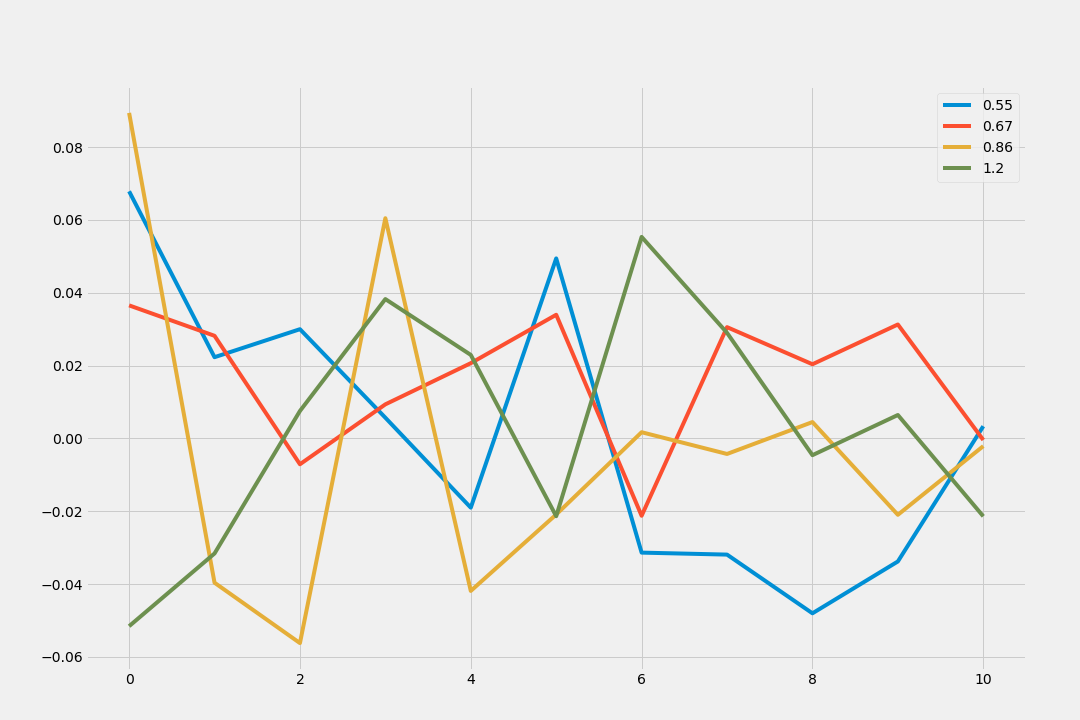

In [14]:
fig, axes = plt.subplots(1,1, figsize=(15, 10))
plt.plot(across_mask[0,...,0,1].transpose())
plt.legend(speeds)
plt.show()

In [ ]:
fn_data = '/mnt/labshare/Markus/Nacho2Markus/results_within/{}_results_'.format(10) + dataset_name + '.npy'
(scores_train, scores_test) = get_participant_scores(fn_data)

In [12]:
import seaborn as sns

In [13]:
plt.style.use('fivethirtyeight')

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(15, 10))

plt.plot(np.mean(across_mask[0, ..., 1], axis=-1).transpose())
plt.plot(across_mask[0, 0, ..., 1], 'k.')
plt.legend(speeds)
plt.gca().set_xlabel('TR Shift')
plt.gca().set_ylabel('Pearson r')
plt.show()

In [ ]:
plt.close('all')

In [ ]:
across_mask.shape

In [ ]:
# speeds = [0.55, 0.67, 0.86, 1.2]
# across_mask = []
# for chosen_mask in masks:
#     across_speed = []
#     for chosen_speed in speeds:
#         across_shift = []
#         for chosen_shift in shifts:
#             for participant_idx in range(0, 34):
#                 dataset_name = 'roi{}_speed{}_shift{}'.format(chosen_mask, str(chosen_speed).replace('.',''), chosen_shift)
#                 fn_data = '/mnt/labshare/Markus/Nacho2Markus/results_within/{}_results_'.format(participant_idx) + dataset_name + '.npy'
#                 evaluation = np.load(fn_data, allow_pickle=True)[()]
#                 evaluation = evaluation[list(evaluation.keys())[0]]

#                 asd
#                 across_subs = []
#                 for key, item in evaluation.items():
#                     asd
#                     df_scores = util.get_model_scores(item['real_y'], item['pred_y'], item['euc_pred'], percentile_cut=80)
#                     across_subs.append(df_scores['Pearson']['Mean'].Refined)
#             across_shift.append(across_subs)
#         across_speed.append(across_shift)
#     across_mask.append(across_speed)
# across_mask = np.array(across_mask)